# Data Exploration 

In this notebook I briefly explore the dataset and investigate if there any possible problems that needs to be adressed in the training pipeline.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pitch_geo.vis_utils as vis_utils

random.seed(1)

In [2]:
df = pd.read_csv('../data/df_keypoints.csv')
df.head(5)

x    y  vis  kid dataset  \
0   532  158    2    1   train   
1  1732  227    2    2   train   
2     0    0    0    3   train   
3     0    0    0    4   train   
4   359  203    2    5   train   

                                        image_path  
0  images/train/c814ce8e31e077df861c2848fe14fb.jpg  
1  images/train/c814ce8e31e077df861c2848fe14fb.jpg  
2  images/train/c814ce8e31e077df861c2848fe14fb.jpg  
3  images/train/c814ce8e31e077df861c2848fe14fb.jpg  
4  images/train/c814ce8e31e077df861c2848fe14fb.jpg

In [3]:
df_train = df[df['dataset'] == 'train'].copy()
df_test = df[df['dataset'] == 'test'].copy()

## How does the images look like?

Let's plot a few images together with their keypoints.

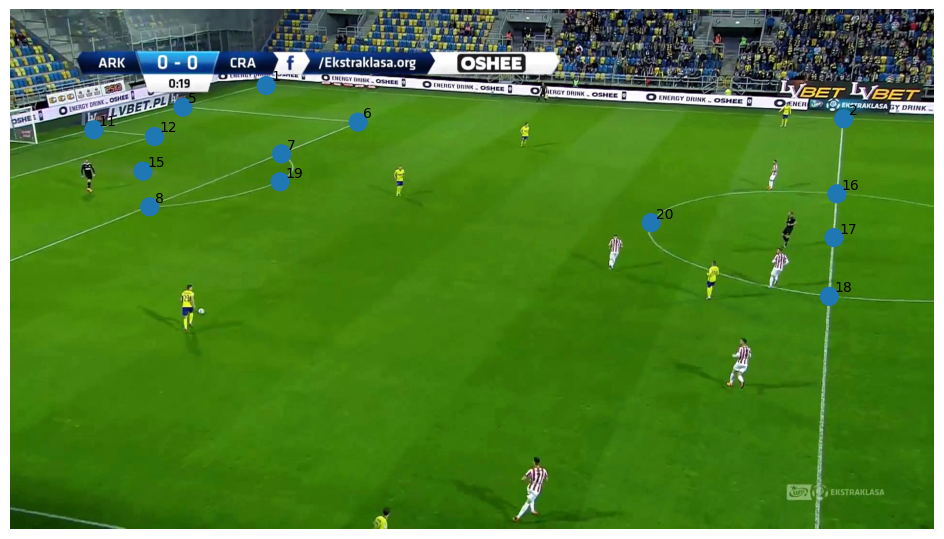

In [4]:
vis_utils.visualize_keypoints(image_path='images/train/c814ce8e31e077df861c2848fe14fb.jpg', df=df_train)

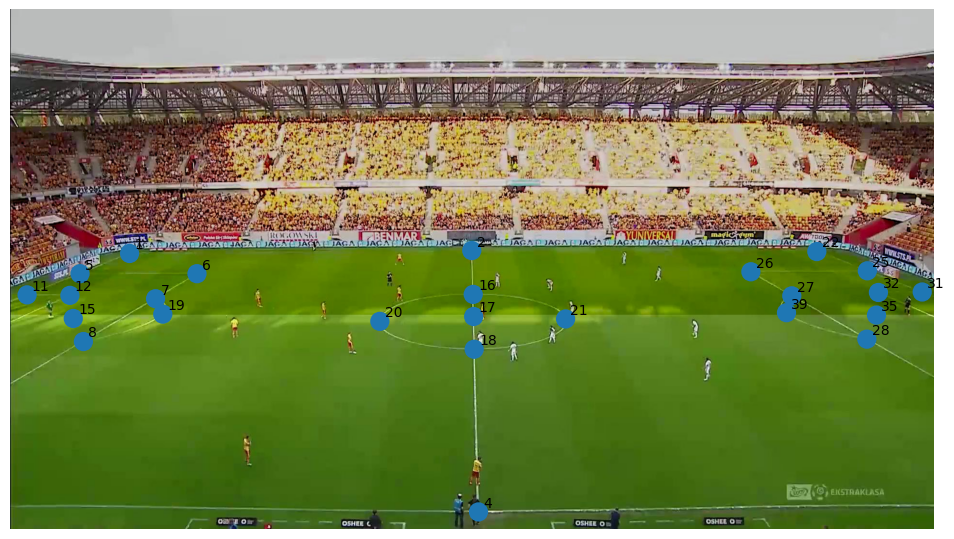

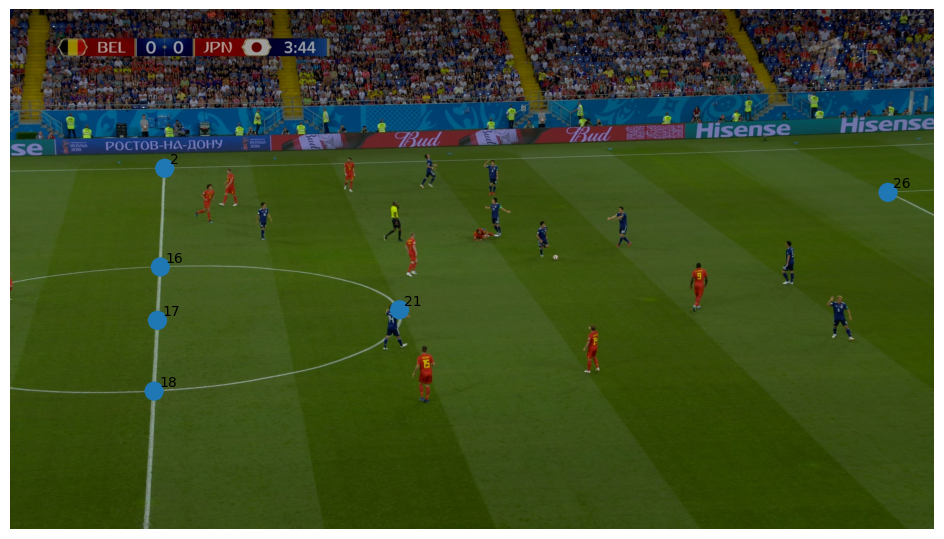

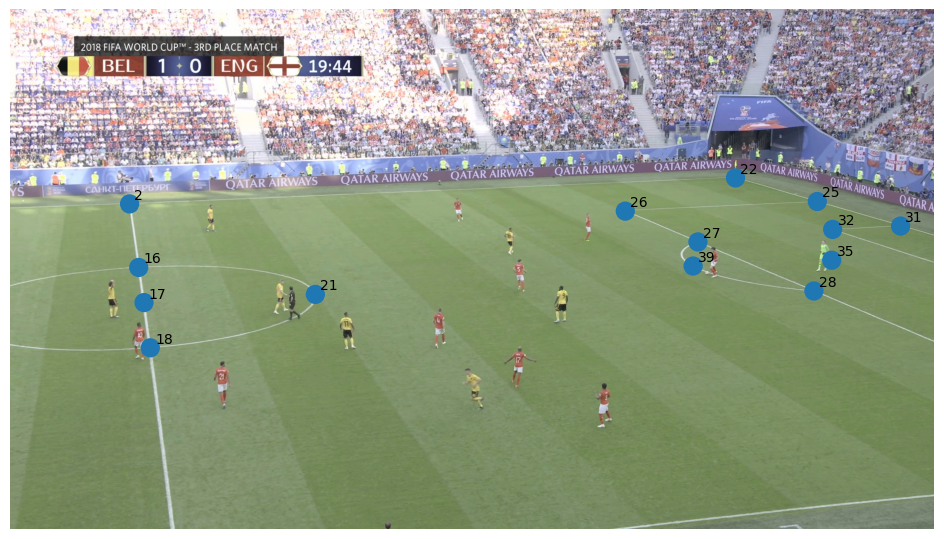

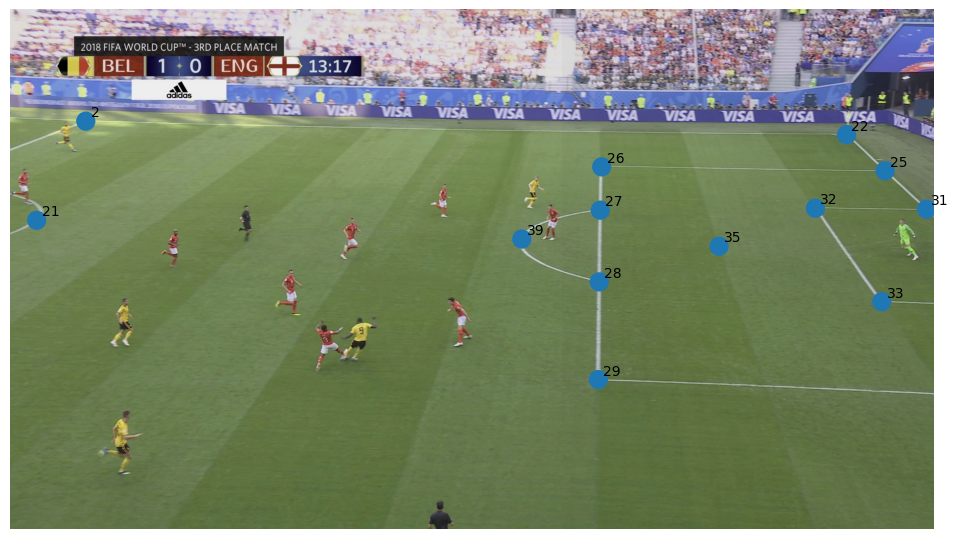

In [5]:
sample_images = random.sample(df_train['image_path'].unique().tolist(), k=4)
for img_path in sample_images:
    vis_utils.visualize_keypoints(img_path, df_train)

You can observe that the frames are quite raw, with additional info being displayed on the screen, shadows or even this weird rectangular area.

## Which keypoints are visible most often and which are most rare?

Firstly let's do a sanity check and see if all the keypoints which are not visible has their coordinates zeroed out.

In [6]:
(df_train[df_train['vis'] == 0][['x', 'y']] == 0.).all()

x    True
y    True
dtype: bool

Yes, all the $x, y$ coordinates are set to 0 if the point is not visible. Let's see keypoints which appear most often:

In [7]:
kid_counts = df_train[df_train['vis'] != 0]['kid'].value_counts()
kid_counts.head(5)

17    1989
16    1978
18    1956
2     1910
20    1877
Name: kid, dtype: int64

... and the most rare keypoints:

In [8]:
kid_counts.tail(5)

34    356
10    150
23     34
3      23
38      1
Name: kid, dtype: int64

Let's put this numbers on a field map:

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/graphs/pitch.png'

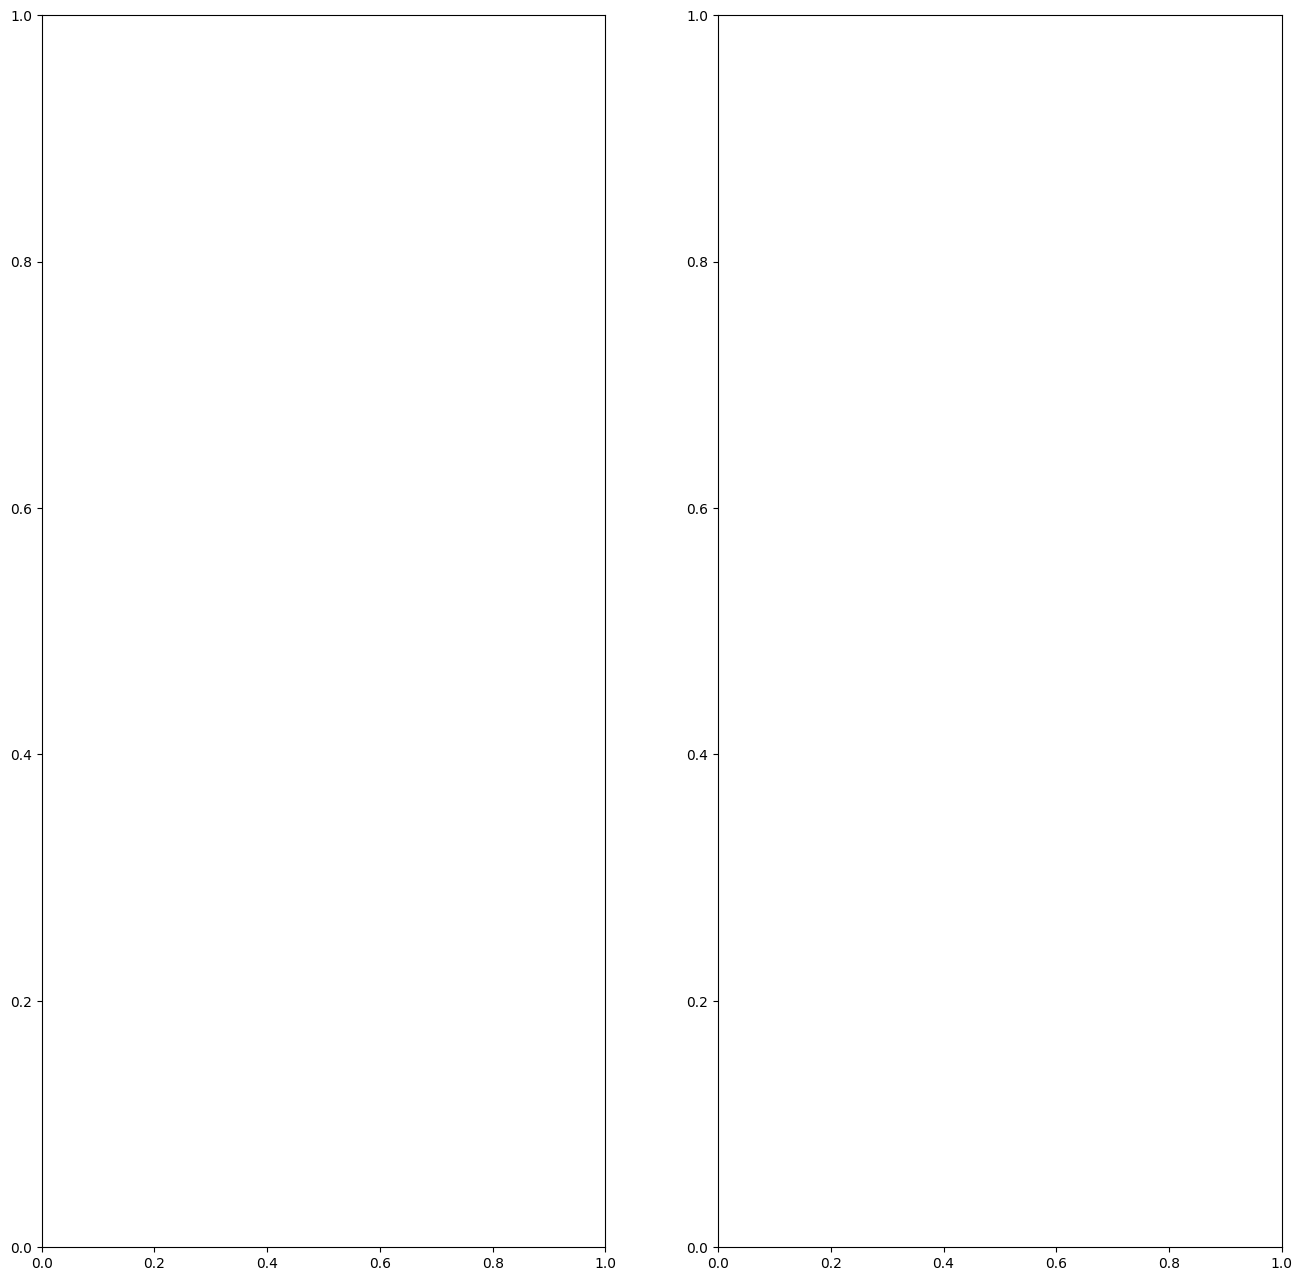

In [9]:
vis_utils.show_field_with_keypoint_frequency(df_train)

We can see that the bottom most corners are very rarely visisble and the model might struggle to recognize them correctly. The points in the pitch's centre are obvioiusly most frequntly visible, but even they are visible only at 50% of all the frames.

But I also noticed some problems with the annotations:

* There is no keypoint '30' annotated, even though it is visible on some frames (see the graphic below).

* Keypoints 24, 36, 37 are never visible and are not present on the map above. They should be dropped before the model is trained.

* There is only one frame where a keypoint '38' is visible. But when I look at that frame it looks as if '38' was mislabelled with '39'. Because of that, I will set this point to be '39' in my training pipeline.

In [ ]:
img_path = 'images/train/0d0365deb03c4703e978f360d5ff72.jpg'
vis_utils.visualize_keypoints(image_path=img_path, df=df)
plt.annotate(text = 'Missing keypoint 30?', xy=(1665, 530), xytext=(1470, 730), arrowprops=dict(facecolor='red', shrink=0.05))
plt.title('Example of a frame with a possible missing keypoint \'30\'')
plt.show()

In [ ]:
img_path = df.query('kid == 38 and vis != 0')['image_path'].item()
vis_utils.visualize_keypoints(image_path=img_path, df=df)
plt.annotate(text = 'Shouldn\'t it be 39?', xy=(1650, 239), xytext=(1310, 500), arrowprops=dict(facecolor='red', shrink=0.05))
plt.title(f'Frame {img_path} with a possibly mislabelled \'39\'')
plt.show()

## Number of visible keypoints per frame

In [ ]:
# It is more convient to work with {0, 1} instead of {0, 2}
df_train['vis'].replace(to_replace=2, value=1, inplace=True)
visibility_sum = df_train.groupby('image_path')['vis'].sum()

In [ ]:
visibility_sum.hist()
plt.title(f"Average number of visible keypoints: {round(df_train.groupby('image_path')['vis'].sum().mean())}")
plt.show()

A we can see, the average number of visible keypoints is 9, out of total 34 keypoints. This means that the vital part of the model would be to guess which points are not visible. I propose to measure the model's performance in doing so by calculating *precision* and *recall* of classificating the keypoints as visible.
High precision would mean that if the model predicts a point to be visible it is very likely to be so. Whereas high recall would mean that every visible keypoint is detected as visible.

Looking at the number of keypoints per frame we can surprisingly notice that there are frames from the train set which doesn't have any keypoint annotated as visible! 
There is 45 such frames. They should be exluded from the train data.

In [ ]:
print(f'Number of frames with no annotated keypoints: {len(visibility_sum[visibility_sum == 0].index)}')

In [ ]:
sample_non_visible = visibility_sum[visibility_sum == 0].index[:4]

In [ ]:
for sample_img_path in sample_non_visible:
    vis_utils.visualize_keypoints(image_path=sample_img_path, df=df_train)